#**Credit Score Classification using PySpark**

## Introduction

In this project, we perform credit score classification using a dataset of credit scores. The goal is to predict a person's credit score category (e.g., good or bad credit) based on various financial features. This classification is essential for financial institutions to assess the risk associated with lending to individuals.

This project leverages PySpark for large-scale data processing and machine learning. We will use classification models such as Logistic Regression and Random Forests for predicting the credit score.

### Dataset
The dataset used in this project is sourced from [Kaggle: Credit Score Classification](https://www.kaggle.com/datasets/parisrohan/credit-score-classification/data). The dataset includes various features related to financial behavior, such as income, debt, payment history, and more.

## Installing Necessary Packages

Before we start, we need to install some required packages. These packages will help us set up the Spark environment and run the machine learning algorithms.

# Install required packages

In [ ]:
!pip install pyspark
!pip install kagglehub

## Importing Libraries

Here we import the necessary libraries for our task. These libraries provide tools for data handling, working with the BERT model, and evaluating our results.

In [ ]:
import kagglehub
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Bucketizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from itertools import chain
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Create Spark session
spark = SparkSession.builder.appName("CreditScoreClassification").getOrCreate()

## Download the Credit Score Dataset

This cell downloads the Credit Score Dataset dataset directly from Kaggle.

In [ ]:
# Download dataset
path = kagglehub.dataset_download("parisrohan/credit-score-classification")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/parisrohan/credit-score-classification/versions/1


## Loading the Credit Score Dataset

In [ ]:
# Read the data (without inferSchema)
# df = spark.read.csv("/root/.cache/kagglehub/datasets/parisrohan/credit-score-classification/versions/1/train.csv", header=True)



# Try to download dataset
try:
    print("Downloading dataset from Kaggle...")
    path = kagglehub.dataset_download("parisrohan/credit-score-classification")
    print(f"Dataset downloaded to: {path}")

    # Try Colab path first
    try:
        print("\nAttempting to read using Colab path...")
        df = spark.read.csv("/root/.cache/kagglehub/datasets/parisrohan/credit-score-classification/versions/1/train.csv", header=True)
        print("Successfully loaded dataset using Colab path")
    except Exception as e1:
        print(f"Colab path attempt failed: {str(e1)}")

        # Try Databricks kaggle download path
        try:
            print("\nAttempting to read using Databricks downloaded path...")
            df = spark.read.csv(f"{path}/train.csv", header=True)
            print("Successfully loaded dataset using Databricks downloaded path")
        except Exception as e2:
            print(f"Databricks downloaded path attempt failed: {str(e2)}")

            # Try default Databricks FileStore path as last resort
            try:
                print("\nAttempting to read using Databricks FileStore path...")
                df = spark.read.csv("/FileStore/tables/train.csv", header=True)
                print("Successfully loaded dataset using Databricks FileStore path")
            except Exception as e3:
                print(f"Databricks FileStore path attempt failed: {str(e3)}")
                raise Exception("""
                Failed to load dataset from all possible paths.
                Attempted paths:
                1. Colab path: /root/.cache/kagglehub/...
                2. Databricks downloaded path: {path}/train.csv
                3. Databricks FileStore path: /FileStore/tables/train.csv

                If using Databricks and none of the paths worked, please ensure train.csv
                is uploaded to '/FileStore/tables/'
                """)

except Exception as e:
    print(f"Error in dataset download or loading: {str(e)}")
    raise

print(f"\nDataset loaded successfully with {df.count():,} rows")

    
# About the Dataset

This dataset provides a comprehensive view of customer profiles, encompassing demographic details, financial histories, and payment patterns that play a crucial role in evaluating credit risk. The goal is to clean and analyze this data to identify key features suitable for training Machine Learning and Deep Learning Algorithms.

- **Dataset:** Credit Score Dataset  
- **Content:** Customer demographic, financial, and credit history data.  
- **Number of Rows:** 100 000
- **Number of Columns:** 28  

| **No** | **INPUTS**                  | **Description**                                                                                  |
|-------|-----------------------------|--------------------------------------------------------------------------------------------------|
| 1     | **id**                       | Unique identifier for each record.                                                               |
| 2     | **customer_id**              | Unique identifier for each customer.                                                             |
| 3     | **month**                    | Month of the transaction or record.                                                              |
| 4     | **name**                     | Customer’s name.                                                                                 |
| 5     | **age**                      | The customer’s age.                                                                              |
| 6     | **ssn**                      | Customer’s social security number.                                                               |
| 7     | **occupation**               | The customer’s occupation.                                                                       |
| 8     | **annual_income**            | The customer’s annual income.                                                                    |
| 9     | **monthly_inhand_salary**    | The customer’s monthly take-home salary.                                                         |
| 10    | **num_bank_accounts**        | Total number of bank accounts owned by the customer.                                            |
| 11    | **num_credit_card**          | Total number of credit cards held by the customer.                                              |
| 12    | **interest_rate**            | The interest rate applied to loans or credits.                                                  |
| 13    | **num_of_loan**              | Number of loans the customer has taken.                                                          |
| 14    | **type_of_loan**             | Categories of loans obtained by the customer.                                                   |
| 15    | **delay_from_due_date**      | The delay in payment relative to the due date.                                                 |
| 16    | **num_of_delayed_payment**   | Total instances of late payments made by the customer.                                          |
| 17    | **changed_credit_limit**     | Adjustments made to the customer’s credit limit.                                               |
| 18    | **num_credit_inquiries**     | Number of inquiries made regarding the customer's credit.                                       |
| 19    | **credit_mix**               | The variety of credit types the customer uses (e.g., loans, credit cards).                     |
| 20    | **outstanding_debt**         | Total amount of debt the customer currently owes.                                              |
| 21    | **credit_utilization_ratio** | Proportion of credit used compared to the total credit limit.                                   |
| 22    | **credit_history_age**       | Duration of the customer’s credit history.                                                      |
| 23    | **payment_of_min_amount**    | Indicates if the customer pays the minimum required amount each month.                         |
| 24    | **total_emi_per_month**      | Total Equated Monthly Installment (EMI) paid by the customer.                                   |
| 25    | **amount_invested_monthly**  | Monthly investment amount made by the customer.                                                 |
| 26    | **payment_behaviour**        | Customer’s payment habits and tendencies.                                                       |
| 27    | **monthly_balance**          | The remaining balance in the customer’s account at the end of each month.                      |
| 28    | **credit_score**             | The customer’s credit score (target variable: "Good," "Poor," "Standard").                     |

## Column Groups

The dataset's columns are categorized into the following groups for preprocessing and analysis:

**1. Columns to Drop:**

These columns are deemed irrelevant or redundant for credit score prediction and will be removed from the dataset.

| Column Name             | Description                                                                   |
|--------------------------|-------------------------------------------------------------------------------|
| **ID**                     | Unique identifier (likely redundant).                                           |
| **Customer_ID**            | Unique customer identifier (likely redundant).                                  |
| **Month**                  | Month of the transaction or record (potentially irrelevant for prediction). |
| **Name**                   | Customer's name (irrelevant for prediction).                                  |
| **SSN**                    | Social Security Number (irrelevant and sensitive information).                   |
| **Type_of_Loan**           | Loan type (detailed analysis might reveal useful information, but omitted for this analysis)             |
| **Changed_Credit_Limit**  | Changes to credit limit (handled implicitly by other features). |
| **Monthly_Inhand_Salary**   | Monthly in-hand salary (might be correlated with annual income).|


**2. Numeric Columns:**

These columns represent numerical features that can be directly used for model training.

| Column Name                   | Description                                                                          |
|-------------------------------|--------------------------------------------------------------------------------------|
| **Age**                          | Customer's age.                                                                     |
| **Annual_Income**                | Annual income.                                                                       |
| **Num_Bank_Accounts**            | Number of bank accounts.                                                              |
| **Num_Credit_Card**              | Number of credit cards.                                                              |
| **Interest_Rate**                | Interest rate on loans.                                                             |
| **Num_of_Loan**                  | Number of loans.                                                                     |
| **Delay_from_due_date**          | Delay in payments.                                                                  |
| **Num_of_Delayed_Payment**       | Number of delayed payments.                                                          |
| **Num_Credit_Inquiries**         | Number of credit inquiries.                                                           |
| **Outstanding_Debt**             | Outstanding debt.                                                                     |
| **Credit_Utilization_Ratio**     | Credit utilization ratio.                                                             |
| **Total_EMI_per_month**          | Total Equated Monthly Installment.                                                  |
| **Amount_invested_monthly**     | Amount invested monthly.                                                             |
| **Monthly_Balance**              | Monthly balance in the account.                                                        |


**3. Categorical Columns:**

These columns represent categorical features and will require encoding before being used for model training.

| Column Name            | Description                                                 |
|-------------------------|-------------------------------------------------------------|
| **Occupation**            | Customer's occupation.                                         |
| **Payment_Behaviour**      | Payment behavior.                                           |
| **Credit_Mix**            | Mix of credit types used.                                      |

In [ ]:
# Define column groups
columns_to_drop = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Type_of_Loan',
                   'Changed_Credit_Limit', 'Monthly_Inhand_Salary']
numeric_columns = ['Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
                  'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                  'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                  'Credit_Utilization_Ratio', 'Total_EMI_per_month',
                  'Amount_invested_monthly', 'Monthly_Balance']
categorical_columns = ['Occupation', 'Payment_Behaviour', 'Credit_Mix']

## Data Preprocessing

The code implementation for these preprocessing steps involves using PySpark's DataFrame API to drop columns and define lists of numeric and categorical features.  Further preprocessing steps (handling missing values, encoding, and scaling) would typically follow.

In [ ]:
# Data Preprocessing
print("\nStarting data preprocessing...")

# Drop unnecessary columns
df = df.drop(*columns_to_drop)


Starting data preprocessing...


In [ ]:
# Handle Credit Mix
df = df.fillna('Unknown', subset=['Credit_Mix'])

# Handling Credit History Age

The function `process_credit_history` processes the `Credit_History_Age` column in the dataset, which is typically formatted as "X Years" or "X Months". The goal is to extract these values and create two separate columns representing the credit history in terms of years and months, and convert them to numeric values for further analysis.


In [ ]:
# Handle Credit History Age
def process_credit_history(data):
    """Process Credit History Age column"""
    data = data.withColumn('Credit_History_Years',
                          F.regexp_extract(F.col('Credit_History_Age'), r'(\d+) Years', 1))
    data = data.withColumn('Credit_History_Months',
                          F.regexp_extract(F.col('Credit_History_Age'), r'(\d+) Months', 1))

    # Convert Credit History columns to numeric
    data = data.withColumn('Credit_History_Years',
                          F.col('Credit_History_Years').cast(IntegerType()))
    data = data.withColumn('Credit_History_Months',
                          F.col('Credit_History_Months').cast(IntegerType()))
    return data.drop('Credit_History_Age')

df = process_credit_history(df)

# Add Credit History columns to numeric columns
numeric_columns.extend(['Credit_History_Years', 'Credit_History_Months'])

# Data Cleaning for Numeric and Categorical Columns

This code cleans both numeric and categorical columns in the dataset, ensuring they are properly formatted for analysis or machine learning models.

## Cleaning Numeric Columns

The `clean_numeric_column` function:
- Removes non-numeric characters from numeric columns.
- Converts valid numeric values to `DoubleType`.
- Replaces invalid values with `None`.

This is applied to all columns in the `numeric_columns` list.

## Cleaning Categorical Columns

For each categorical column:
- Missing or empty values are replaced with `'Other'`.


In [ ]:
# Clean numeric columns
def clean_numeric_column(df, column):
    """Clean a numeric column by removing non-numeric characters and converting to double"""
    return df.withColumn(
        column,
        F.when(
            F.col(column).cast("string").rlike('^[0-9]+\.?[0-9]*$'),
            F.col(column).cast("string").cast(DoubleType())
        ).otherwise(None)
    )

# Apply numeric cleaning to both datasets
for column in numeric_columns:
    df = clean_numeric_column(df, column)

# Clean categorical columns
for column in categorical_columns:
    df = df.withColumn(column,
                      F.when(F.col(column).isNull() | (F.col(column) == ''), 'Other')
                      .otherwise(F.col(column)))


# Transforming Target Variable

This code transforms the target variable, `Credit_Score`, into numeric values based on predefined categories.

## Process

- A mapping dictionary `target_mapping` is defined, where categories ('Poor', 'Standard', 'Good') are mapped to numeric values (0.0, 1.0, 2.0).
- The mapping is applied to the `Credit_Score` column, converting it to a `DoubleType` based on the category values.


In [ ]:
# Transform target variable
target_mapping = {'Poor': 0.0, 'Standard': 1.0, 'Good': 2.0}
mapping_expr = F.create_map([F.lit(x) for x in chain(*target_mapping.items())])
df = df.withColumn('Credit_Score',
                   mapping_expr.getItem(F.col('Credit_Score')).cast(DoubleType()))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


# Data Quality Check and Conversion to Pandas

## Data Quality Check

- The code performs a data quality check by counting the number of `null` values in each column.
- For each column, it calculates the percentage of missing values and prints the results.

## Convert Spark DataFrame to Pandas

- A sample of the DataFrame (10% of the data) is converted to a Pandas DataFrame for easier visualization.


In [ ]:
# Print initial data quality check
print("\nData Quality Check after Preprocessing:")
for column in df.columns:
    null_count = df.filter(F.col(column).isNull()).count()
    total_count = df.count()
    print(f"{column}: {null_count} nulls ({(null_count/total_count)*100:.2f}%)")

# Convert a sample of Spark DataFrame to Pandas for visualization
pandas_df = df.sample(fraction=0.1, seed=42).toPandas()


Data Quality Check after Preprocessing:
Age: 5825 nulls (5.83%)
Occupation: 0 nulls (0.00%)
Annual_Income: 6980 nulls (6.98%)
Num_Bank_Accounts: 21 nulls (0.02%)
Num_Credit_Card: 0 nulls (0.00%)
Interest_Rate: 0 nulls (0.00%)
Num_of_Loan: 8661 nulls (8.66%)
Delay_from_due_date: 591 nulls (0.59%)
Num_of_Delayed_Payment: 10368 nulls (10.37%)
Num_Credit_Inquiries: 1965 nulls (1.97%)
Credit_Mix: 0 nulls (0.00%)
Outstanding_Debt: 1009 nulls (1.01%)
Credit_Utilization_Ratio: 0 nulls (0.00%)
Payment_of_Min_Amount: 0 nulls (0.00%)
Total_EMI_per_month: 0 nulls (0.00%)
Amount_invested_monthly: 8784 nulls (8.78%)
Payment_Behaviour: 0 nulls (0.00%)
Monthly_Balance: 1209 nulls (1.21%)
Credit_Score: 0 nulls (0.00%)
Credit_History_Years: 9030 nulls (9.03%)
Credit_History_Months: 9030 nulls (9.03%)


# Exploratory Data Analysis
## Credit Utilization Ratio by Credit Score

This box plot shows the distribution of the Credit Utilization Ratio across different Credit Score categories:
- **0.0 (Poor)**: Lower range of credit utilization.
- **1.0 (Standard)**: Similar utilization as the "Poor" category.
- **2.0 (Good)**: No significant difference in utilization across categories.

The chart helps visualize the spread and central tendency of credit utilization ratios for each credit score group.


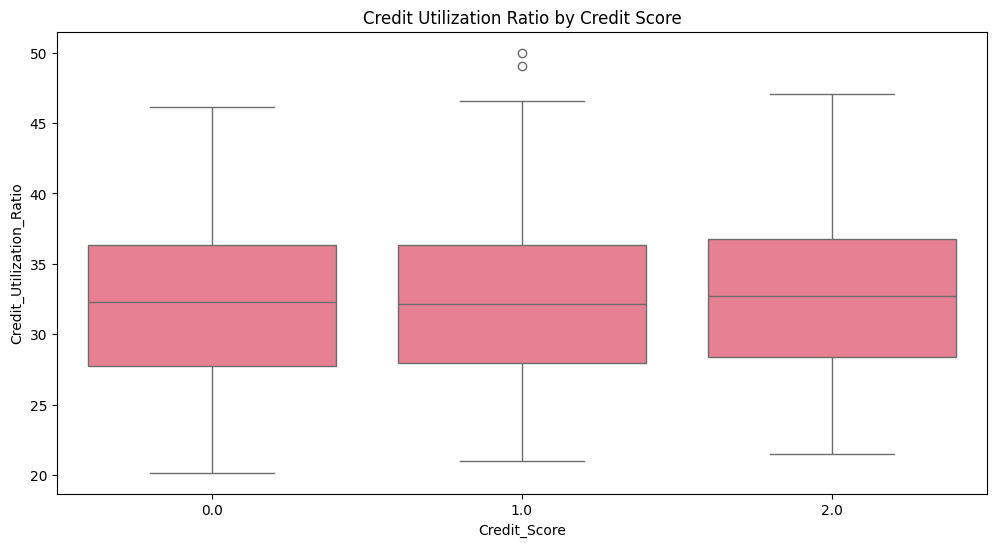

In [ ]:
# Exploratory Data Analysis

#Credit Utilization Ratio Distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=pandas_df, x='Credit_Score', y='Credit_Utilization_Ratio')
plt.title('Credit Utilization Ratio by Credit Score')
plt.show()


## Payment Behaviour Distribution by Credit Score

This horizontal bar plot shows the distribution of payment behavior across different credit score categories:
- **0.0 (Poor)**: Individuals in this group tend to show a wide distribution of payment behaviors, including both low and high payment values.
- **1.0 (Standard)**: A mix of medium to high value payments.
- **2.0 (Good)**: Individuals here exhibit more consistent patterns, especially in the high-value payment categories.

The chart provides insights into how different payment behaviors (e.g., high vs. low spending, small vs. large value payments) are distributed across various credit score groups.


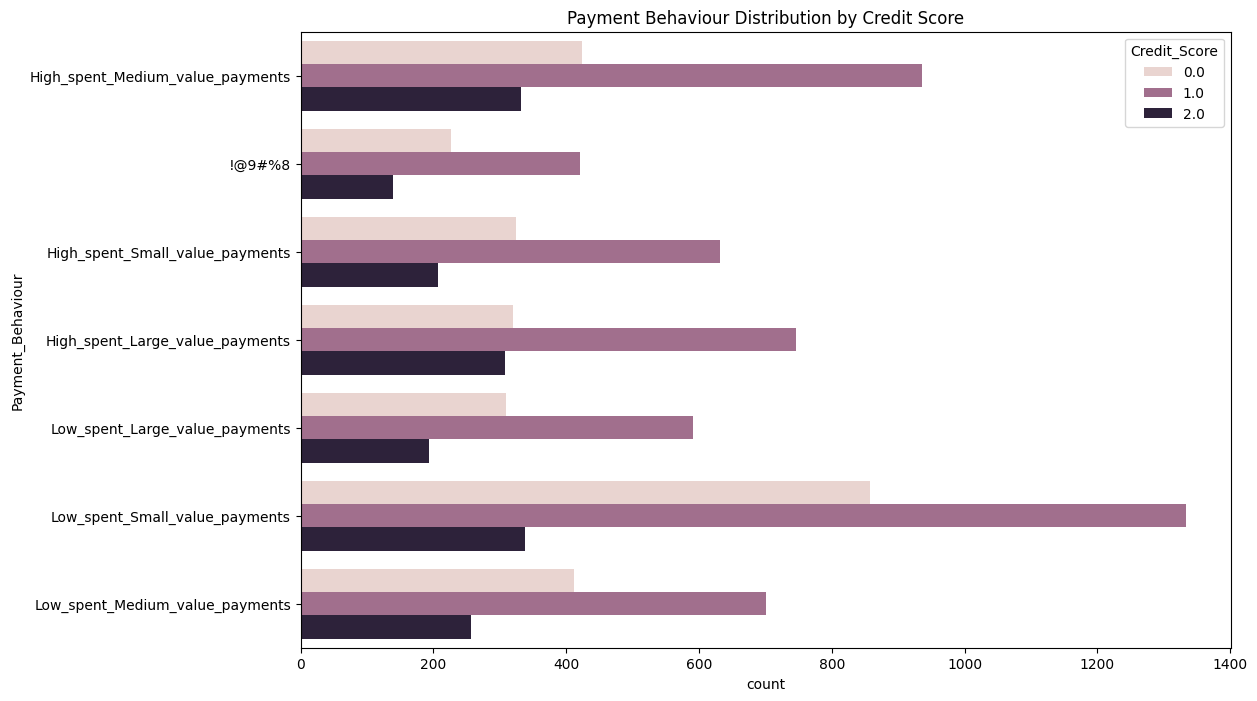

In [ ]:
    plt.figure(figsize=(12, 8))
    sns.countplot(data=pandas_df, y='Payment_Behaviour', hue='Credit_Score')
    plt.title('Payment Behaviour Distribution by Credit Score')
    plt.show()

## Distribution of Credit Scores

This bar plot visualizes the distribution of credit scores across different credit mixes:
- **Good**: The group with the "Good" credit mix shows a relatively balanced distribution across different credit scores, but with fewer individuals compared to the "Standard" category.
- **Standard**: This category dominates the chart with a large number of individuals in the "Standard" credit mix, particularly for the "Standard" credit score.
- **Bad**: A smaller portion of individuals have a "Bad" credit mix, with a notable but lesser number for the "Poor" credit score category.

This chart helps to understand how credit scores are distributed within different credit mixes, indicating trends in creditworthiness.


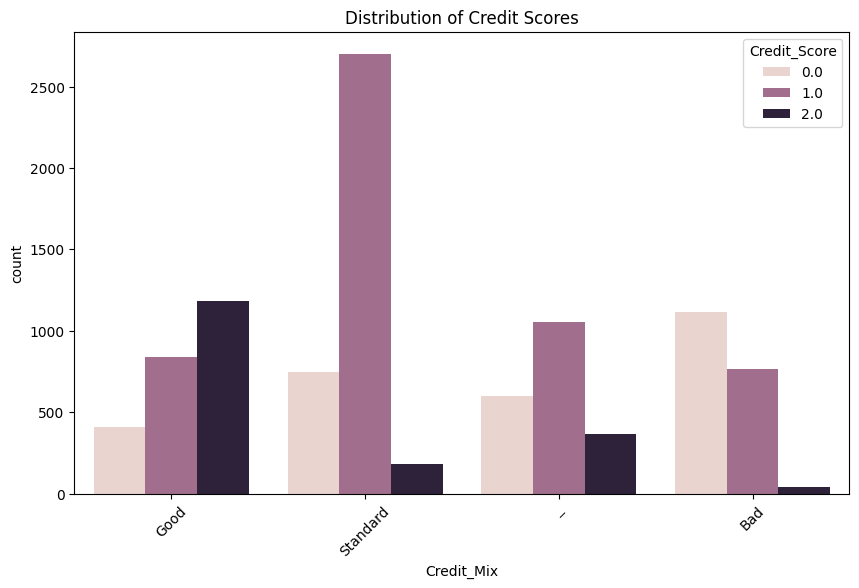

In [ ]:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=pandas_df, x='Credit_Mix',hue="Credit_Score")
    plt.title('Distribution of Credit Scores')
    plt.xticks(rotation=45)
    plt.show()

## Distribution of Credit Scores by Occupation

This bar plot shows the distribution of credit scores across various occupations:
- **Occupations** like Scientist, Lawyer, and Developer show a higher concentration of individuals with good credit scores (2.0), while other occupations like Teacher and Mechanic have a more balanced distribution across credit score categories.
- **Credit Scores**:
  - **0.0 (Poor)**: Occupations like Developer and Writer show fewer individuals with poor credit.
  - **1.0 (Standard)**: Most occupations show a mix of individuals with standard credit scores.
  - **2.0 (Good)**: Occupations like Scientist and Lawyer tend to have a higher number of individuals with good credit scores.

The chart offers insights into how credit scores are distributed across different professions, indicating potential trends in creditworthiness based on occupation.


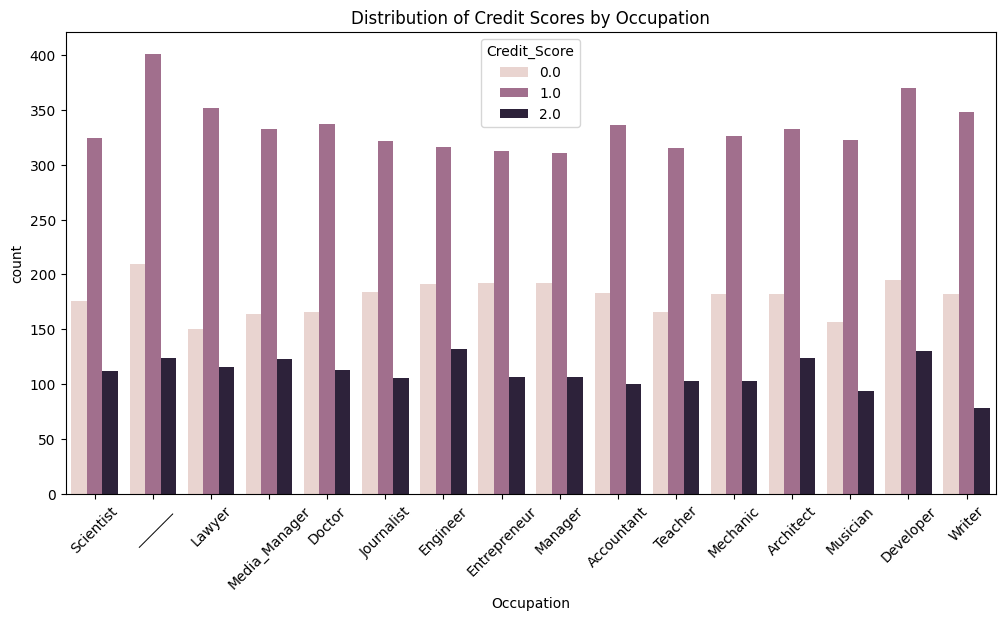

In [ ]:
# prompt: using bar graph what can i plot using this dataset

def plot_credit_score_distribution_by_occupation():
    """Plots a bar graph showing the distribution of credit scores by occupation."""
    plt.figure(figsize=(12, 6))
    sns.countplot(data=pandas_df, x='Occupation', hue='Credit_Score')
    plt.title('Distribution of Credit Scores by Occupation')
    plt.xticks(rotation=45)
    plt.show()

# Generate bar graph for Credit Score distribution by Occupation
plot_credit_score_distribution_by_occupation()

In [ ]:

def replace_value_in_column(df, column_name, old_value, new_value):
  """Replaces specific values in a specified column of a Spark DataFrame.

  Args:
    df: The input Spark DataFrame.
    column_name: The name of the column to modify.
    old_value: The value to be replaced.
    new_value: The new value to replace with.

  Returns:
    A new Spark DataFrame with the replaced values.
  """
  return df.withColumn(column_name, F.when(F.col(column_name) == old_value, new_value).otherwise(F.col(column_name)))

# Example usage:
df = replace_value_in_column(df, 'Payment_Behaviour', '!@9#%8', 'Unknown')
df = replace_value_in_column(df, 'Occupation', '_______', 'Unknown')
df = replace_value_in_column(df, 'Credit_Mix', '_', 'Unknown')


# After Exploratory Data anlysis and Cleaning

## Distribution of Credit Scores by Occupation

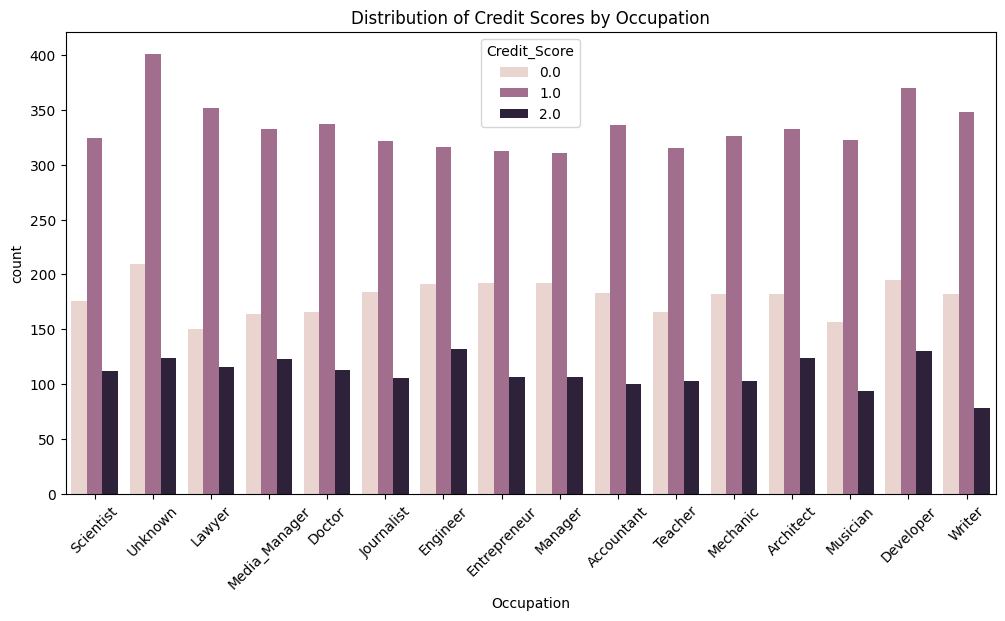

In [ ]:
# Convert a sample of Spark DataFrame to Pandas for visualization
pandas_df = df.sample(fraction=0.1, seed=42).toPandas()

# prompt: using bar graph what can i plot using this dataset

def plot_credit_score_distribution_by_occupation():
    """Plots a bar graph showing the distribution of credit scores by occupation."""
    plt.figure(figsize=(12, 6))
    sns.countplot(data=pandas_df, x='Occupation', hue='Credit_Score')
    plt.title('Distribution of Credit Scores by Occupation')
    plt.xticks(rotation=45)
    plt.show()

# Generate bar graph for Credit Score distribution by Occupation
plot_credit_score_distribution_by_occupation()

# Feature Engineering

Feature engineering is a critical step to enhance the predictive power of machine learning models. In this process, new features are created through interactions, ratios, and bins. Additionally, outlier handling is applied to improve data quality.

## Key Steps in Feature Engineering

### 1. **Interaction Features**
   - **EMI to Income Ratio**: This feature measures the proportion of monthly EMI payments relative to monthly income.
   - **Debt to Income Ratio**: This ratio represents the relationship between outstanding debt and annual income.
   - **Utilization to Income Ratio**: It calculates the credit utilization ratio relative to the income.
   - **Investment to Income Ratio**: This ratio shows the proportion of monthly investment to monthly income.

### 2. **Ratios and Derived Features**
   - **Delayed Payment Ratio**: This feature shows the proportion of delayed payments relative to the total number of loans.
   - **Credit Card Load**: This metric indicates the number of credit cards as a fraction of annual income.

### 3. **Binned Features**
   - Numeric features like `Annual_Income`, `Credit_Utilization_Ratio`, and `Outstanding_Debt` are binned into categories to create more interpretable features. Binning divides the data into intervals based on quantiles, making the features easier to use in models.

### 4. **Outlier Handling**
   - **Interquartile Range (IQR) Method**: Outliers in numeric columns are identified and handled using the IQR method. Any data points outside the defined range are replaced by the upper or lower bounds, ensuring that the model is not influenced by extreme values.


In [ ]:
print("\nPerforming Feature Engineering...")

# Create interaction features
df = df.withColumn('EMI_to_Income',
                   F.col('Total_EMI_per_month') / F.when(F.col('Annual_Income') > 0, F.col('Annual_Income')/12).otherwise(1))
df = df.withColumn('Debt_to_Income',
                   F.col('Outstanding_Debt') / F.when(F.col('Annual_Income') > 0, F.col('Annual_Income')).otherwise(1))
df = df.withColumn('Utilization_to_Income',
                   F.col('Credit_Utilization_Ratio') / F.when(F.col('Annual_Income') > 0, F.col('Annual_Income')).otherwise(1))
df = df.withColumn('Investment_to_Income',
                   F.col('Amount_invested_monthly') / F.when(F.col('Annual_Income') > 0, F.col('Annual_Income')/12).otherwise(1))

# Create ratios and derived features
df = df.withColumn('Delayed_Payment_Ratio',
                   F.col('Num_of_Delayed_Payment') / F.when(F.col('Num_of_Loan') > 0, F.col('Num_of_Loan')).otherwise(1))
df = df.withColumn('Credit_Card_Load',
                   F.col('Num_Credit_Card') / F.when(F.col('Annual_Income') > 0, F.col('Annual_Income')/100000).otherwise(1))

# Create bins for numeric features
def create_bins(df, column, num_bins=5):
    quantiles = df.approxQuantile(column, [x/num_bins for x in range(1, num_bins)], 0.01)
    bucketizer = Bucketizer(splits=[float('-inf')] + quantiles + [float('inf')],
                           inputCol=column,
                           outputCol=f"{column}_binned")
    return bucketizer.transform(df)

# Add binned features for key numeric columns
numeric_to_bin = ['Annual_Income', 'Credit_Utilization_Ratio', 'Outstanding_Debt']
for col in numeric_to_bin:
    df = create_bins(df, col)

# Add new features to numeric_columns
new_numeric_features = ['EMI_to_Income', 'Debt_to_Income', 'Utilization_to_Income',
                       'Investment_to_Income', 'Delayed_Payment_Ratio', 'Credit_Card_Load']
numeric_columns.extend(new_numeric_features)

# 2. Improved Data Cleaning
# Handle outliers using IQR method
def handle_outliers(df, column):
    # Calculate Q1, Q3 and IQR
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with bounds
    return df.withColumn(
        column,
        F.when(F.col(column) > upper_bound, upper_bound)
         .when(F.col(column) < lower_bound, lower_bound)
         .otherwise(F.col(column))
    )

# Apply outlier handling to numeric columns
for column in numeric_columns:
    df = handle_outliers(df, column)


Performing Feature Engineering...


# Enhanced Pipeline Creation and Model Training

This section outlines the process of creating an enhanced pipeline with improved feature processing, handling class imbalance, and training a logistic regression model with advanced features and better parameters.

## 1. **Enhanced Pipeline Creation**

The pipeline consists of several stages for both numeric and categorical features:
- **Imputation**: Missing values in numeric columns are imputed using the mean of each column.
- **Feature Scaling**: Numeric features are standardized using a combination of standardization and min-max scaling.
- **Categorical Feature Processing**: Categorical columns are indexed and then encoded using one-hot encoding.
- **Feature Assembly**: Both scaled numeric features and encoded categorical features are combined into a single feature vector for model input.

## 2. **Class Imbalance Handling**

To address class imbalance in the dataset:
- Class weights are calculated based on the distribution of `Credit_Score` classes. These weights are used to penalize the underrepresented classes during training, ensuring the model treats all classes more equitably.

## 3. **Train-Test Split with Stratification**

The dataset is split into training and validation sets using stratified sampling. This ensures that the class distribution is preserved across both sets, making the model evaluation more reliable.

## 4. **Enhanced Logistic Regression**

The logistic regression model is enhanced with the following adjustments:
- **Multinomial family** for multi-class classification.
- **ElasticNet regularization** with a mix of L1 and L2 penalties.
- **Class Weights** applied to balance the class distribution during training.
- The model is trained with a parameter grid search for tuning the regularization strength (`regParam`), elastic net parameter (`elasticNetParam`), and maximum iterations (`maxIter`).

## 5. **Cross-validation**

Cross-validation is used to find the optimal model parameters by evaluating multiple configurations across 5 folds. The model's performance is evaluated using the accuracy metric, and a confusion matrix is generated to visualize class-wise performance.

## 6. **Model Evaluation**

After training, the model's performance is evaluated on the validation set using multiple metrics:
- **Accuracy**
- **Weighted Precision**
- **Weighted Recall**
- **F1 Score**

A confusion matrix is also generated to visualize the predictions for each class.

In [ ]:
# 3. Enhanced Pipeline Creation
def create_enhanced_pipeline():
    """Create enhanced pipeline with better feature processing"""

    # Initial imputer for numeric columns
    imputer = Imputer(
        inputCols=numeric_columns,
        outputCols=[f"{col}_imputed" for col in numeric_columns],
        strategy="mean"
    )

    # Create feature scalers
    numeric_assembler = VectorAssembler(
        inputCols=[f"{col}_imputed" for col in numeric_columns],
        outputCol="numeric_features",
        handleInvalid="keep"
    )

    # Use both standardization and min-max scaling
    standard_scaler = StandardScaler(
        inputCol="numeric_features",
        outputCol="scaled_numeric_features",
        withStd=True,
        withMean=True
    )

    # Process categorical features
    indexers = [StringIndexer(inputCol=col,
                             outputCol=f"{col}_indexed",
                             handleInvalid="keep")
               for col in categorical_columns]

    encoders = [OneHotEncoder(inputCol=f"{col}_indexed",
                             outputCol=f"{col}_encoded",
                             handleInvalid="keep")
               for col in categorical_columns]

    # Combine all features
    assembler = VectorAssembler(
        inputCols=["scaled_numeric_features"] +
                 [f"{col}_encoded" for col in categorical_columns],
        outputCol="features",
        handleInvalid="keep"
    )

    return [imputer] + [numeric_assembler] + [standard_scaler] + indexers + encoders + [assembler]

# 4. Handle Class Imbalance
# Calculate class weights
class_counts = df.groupBy("Credit_Score").count().collect()
total = df.count()
class_weights = {row['Credit_Score']: total / (len(class_counts) * row['count'])
                for row in class_counts}

# 5. Train-Test Split with Stratification
fractions = df.select("Credit_Score").distinct().withColumn(
    "fraction", F.lit(0.8)
).rdd.collectAsMap()

train_data = df.sampleBy("Credit_Score", fractions, seed=42)
val_data = df.subtract(train_data)

# 6. Enhanced Logistic Regression with Better Parameters
lr = LogisticRegression(
    labelCol="Credit_Score",
    featuresCol="features",
    maxIter=100,
    family="multinomial",
    standardization=False,
    elasticNetParam=0.5,
    weightCol="weight"
)

# Add weight column based on class weights
def add_weight_column(dataset):
    return dataset.withColumn(
        "weight",
        F.when(F.col("Credit_Score") == 0.0, class_weights[0.0])
         .when(F.col("Credit_Score") == 1.0, class_weights[1.0])
         .otherwise(class_weights[2.0])
    )

train_data = add_weight_column(train_data)
val_data = add_weight_column(val_data)

# Create pipeline with enhanced features
lr_pipeline = Pipeline(stages=create_enhanced_pipeline() + [lr])

# Enhanced parameter grid
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0,0.5]) \
    .addGrid(lr.maxIter, [300,500]) \
    .build()



# Cross-validation with multiple metrics
lr_cv = CrossValidator(
    estimator=lr_pipeline,
    estimatorParamMaps=lr_paramGrid,
    evaluator=MulticlassClassificationEvaluator(
        labelCol="Credit_Score",
        predictionCol="prediction",
        metricName="accuracy"
    ),
    numFolds=5,
    seed=42
)

# Train model
print("\nTraining enhanced model...")
lr_model = lr_cv.fit(train_data)
lr_predictions = lr_model.transform(val_data)

# Evaluate model with multiple metrics
def evaluate_model_thoroughly(predictions):
    evaluator = MulticlassClassificationEvaluator(labelCol="Credit_Score",
                                                predictionCol="prediction")

    metrics = {
        'Accuracy': evaluator.setMetricName("accuracy").evaluate(predictions),
        'Weighted Precision': evaluator.setMetricName("weightedPrecision").evaluate(predictions),
        'Weighted Recall': evaluator.setMetricName("weightedRecall").evaluate(predictions),
        'F1 Score': evaluator.setMetricName("f1").evaluate(predictions)
    }

    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Confusion Matrix
    confusion_matrix = predictions.groupBy("Credit_Score", "prediction").count().toPandas()
    confusion_matrix = confusion_matrix.pivot(index="Credit_Score",
                                            columns="prediction",
                                            values="count").fillna(0)
    print("\nConfusion Matrix:")
    print(confusion_matrix)

    return metrics

# Evaluate final model
final_metrics = evaluate_model_thoroughly(lr_predictions)

# Print best parameters
best_model = lr_model.bestModel
best_lr = best_model.stages[-1]
print("\nBest Model Parameters:")
print(f"RegParam: {best_lr.getRegParam()}")
print(f"ElasticNetParam: {best_lr.getElasticNetParam()}")
print(f"MaxIter: {best_lr.getMaxIter()}")


Training enhanced model...

Model Performance Metrics:
Accuracy: 0.6368
Weighted Precision: 0.6846
Weighted Recall: 0.6368
F1 Score: 0.6410

Confusion Matrix:
prediction     0.0   1.0   2.0
Credit_Score                  
0.0           3945   971   908
1.0           2365  5903  2331
2.0            136   538  2863

Best Model Parameters:
RegParam: 0.01
ElasticNetParam: 0.5
MaxIter: 300


# Logistic Regression Model Evaluation

After training the Logistic Regression model on the transformed dataset, the model's performance is evaluated using the accuracy metric.

## Model Accuracy

The accuracy of the Logistic Regression model on the validation dataset is calculated using the `MulticlassClassificationEvaluator`. The model's accuracy indicates the proportion of correct predictions out of all predictions made.

**Logistic Regression Accuracy: 0.6368**

This means that the model correctly predicted the `Credit_Score` category for approximately 63.68% of the samples in the validation set.

In [ ]:
# prompt: for above dataset that is transformed with logisitc regression give accuracy result

# Evaluate Logistic Regression model
lr_evaluator = MulticlassClassificationEvaluator(labelCol="Credit_Score", predictionCol="prediction", metricName="accuracy")
lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

Logistic Regression Accuracy: 0.6368236472945892


# Confusion Matrix for Logistic Regression

The confusion matrix is a useful tool for evaluating the performance of a classification model, showing the true versus predicted labels. For the Logistic Regression model, the confusion matrix is presented as follows:

- **True Labels**: The actual values from the `Credit_Score` column.
- **Predicted Labels**: The values predicted by the Logistic Regression model.

The matrix helps in understanding how well the model performed across different classes.

## Confusion Matrix Breakdown

- **Class 0 (Poor)**:
  - True positives: 3945 (correctly predicted as class 0)
  - False positives: 971 (incorrectly predicted as class 0 when it was class 1)
  - False negatives: 908 (incorrectly predicted as class 0 when it was class 2)

- **Class 1 (Standard)**:
  - True positives: 5903 (correctly predicted as class 1)
  - False positives: 2365 (incorrectly predicted as class 1 when it was class 0)
  - False negatives: 2331 (incorrectly predicted as class 1 when it was class 2)

- **Class 2 (Good)**:
  - True positives: 2863 (correctly predicted as class 2)
  - False positives: 136 (incorrectly predicted as class 2 when it was class 0)
  - False negatives: 538 (incorrectly predicted as class 2 when it was class 1)


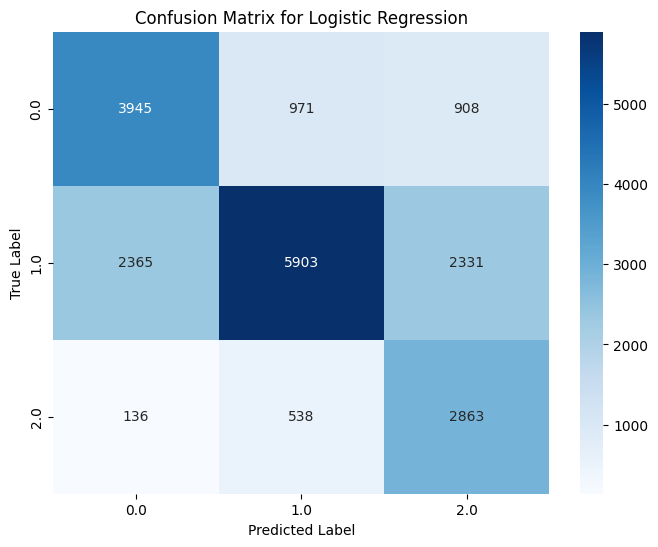

In [ ]:
# prompt: generate prediction visualization for above cell of logistic regression

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'lr_predictions' DataFrame from your code is available

# Extract true labels and predictions
y_true = lr_predictions.select("Credit_Score").toPandas()
y_pred = lr_predictions.select("prediction").toPandas()


# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0.0, 1.0, 2.0], yticklabels=[0.0, 1.0, 2.0])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()


# You can also visualize the predicted probabilities (if available)
# Example (assuming 'probability' column exists in lr_predictions)
# probability_df = lr_predictions.select("Credit_Score", "probability").toPandas()
# sns.histplot(data=probability_df, x="probability", hue="Credit_Score", element="step")
# plt.xlabel("Predicted Probability")
# plt.ylabel("Frequency")
# plt.title("Distribution of Predicted Probabilities by Credit Score")
# plt.show()

For milestone 2

In [ ]:
# # for Milestone 2
# # 2. Random Forest Model
# print("\nTraining Random Forest Model...")

# rf = RandomForestClassifier(labelCol="Credit_Score",
#                            featuresCol="features",
#                            numTrees=100)

# rf_pipeline = Pipeline(stages=create_base_pipeline() + [rf])

# # Parameter grid for Random Forest
# rf_paramGrid = ParamGridBuilder() \
#     .addGrid(rf.maxDepth, [5, 10]) \
#     .addGrid(rf.minInstancesPerNode, [1, 2]) \
#     .build()

# # Cross-validation for Random Forest
# rf_cv = CrossValidator(estimator=rf_pipeline,
#                       estimatorParamMaps=rf_paramGrid,
#                       evaluator=MulticlassClassificationEvaluator(labelCol="Credit_Score",
#                                                                 predictionCol="prediction",
#                                                                 metricName="accuracy"),
#                       numFolds=3)

# # Fit Random Forest model
# rf_model = rf_cv.fit(train_data)
# rf_predictions = rf_model.transform(val_data)

# # Model Evaluation
# def evaluate_model(predictions, model_name):
#     """Evaluate model performance"""
#     evaluator = MulticlassClassificationEvaluator(labelCol="Credit_Score",
#                                                 predictionCol="prediction")

#     accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
#     f1 = evaluator.setMetricName("f1").evaluate(predictions)

#     # Calculate confusion matrix
#     confusion_matrix = predictions.groupBy("Credit_Score", "prediction").count().toPandas()
#     confusion_matrix = confusion_matrix.pivot(index="Credit_Score",
#                                             columns="prediction",
#                                             values="count").fillna(0)

#     print(f"\n{model_name} Performance Metrics:")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"F1 Score: {f1:.4f}")
#     print("\nConfusion Matrix:")
#     print(confusion_matrix)

#     return accuracy, f1, confusion_matrix

# # Evaluate both models
# lr_metrics = evaluate_model(lr_predictions, "Logistic Regression")
# rf_metrics = evaluate_model(rf_predictions, "Random Forest")

# # Compare models
# print("\nModel Comparison:")
# print("Logistic Regression vs Random Forest")
# print(f"LR Accuracy: {lr_metrics[0]:.4f} vs RF Accuracy: {rf_metrics[0]:.4f}")
# print(f"LR F1 Score: {lr_metrics[1]:.4f} vs RF F1 Score: {rf_metrics[1]:.4f}")

# # Make predictions on test data using the better model
# if lr_metrics[0] > rf_metrics[0]:
#     final_model = lr_model
#     print("\nUsing Logistic Regression for final predictions")
# else:
#     final_model = rf_model
#     print("\nUsing Random Forest for final predictions")

# final_predictions = final_model.transform(test_data)

# # Show sample predictions
# print("\nSample Predictions:")
# final_predictions.select("prediction", "probability").show(5)

# # Optional: Save predictions to CSV
# # final_predictions.select("prediction").toPandas().to_csv("credit_score_predictions.csv", index=False)

# print("\nCredit Score Classification Complete!")